## Null models

Question: For the null model, why do we control for graph degrees?


In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import community as community_louvain
import matplotlib.cm as cm


Remember the objective function for modularity, from [Fortunato, 2010](https://arxiv.org/pdf/0906.0612.pdf):

$$
Q = \frac{1}{2m}\sum_{ij}(A_{ij} - P_{ij})\delta(C_i,C_j)
$$

where $m$ is the total number of edges in the graph, $A$ is the adjacency matrix, and $P_{ij}$ is the expected number of edges between i and j according to the apporpriate null model, and $\delta$ is a matrix that denotes whether vertices i and j are within the same community:

$$
\delta(C_i,C_j) = \left\{
                \begin{array}{ll}
                  1\ if\ C_i=C_j\\
                  0\ if\ C_i \neq C_j\\
                \end{array}\right.
$$

In this case the null model is:

$$
P_{ij} = \frac{k_i k_j}{2m}
$$

Let's say that we want to analyze the karate club dataset.  

found 4 communities
modularity =  0.41978961209730437


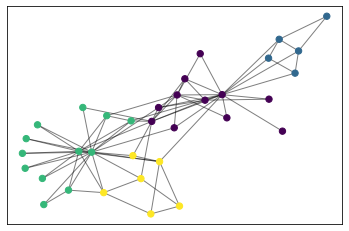

In [24]:
G = nx.karate_club_graph()
partition = community_louvain.best_partition(G)
membership = list(partition.values())
degree = nx.degree(G)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=membership)
nx.draw_networkx_edges(G, pos, alpha=0.5)

print('found %d communities' % len(np.unique(membership)))
print('modularity = ', community_louvain.modularity(partition, G))

In [84]:
def compute_modularity(G, Pmult=1):
    """
    given a networkx graph, compute Newman modularity
    Also allow for different expectations (via P)
    """
    A = nx.to_numpy_array(G)
    m = len(G.edges)
    # get partition matrix and null model matrix
    Pmtx = np.zeros(A.shape)
    C = np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if partition[i] == partition[j]:
                C[i, j] = 1
            Pmtx[i, j] = Pmult * (degree[i] * degree[j]) / (2 * m)


    # compute modularity
    Q = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            Q += (A[i, j] - Pmtx[i, j]) * C[i, j]
    Q = Q / (2 * m)
    return(Q)

Q = compute_modularity(G)
print('Karate club modularity:', Q)
assert np.allclose(Q, community_louvain.modularity(partition, G))

Karate club modularity: 0.41978961209730375


Now let's look at the modularity of random networks.

In [86]:
nruns = 1000
n = len(G.nodes)
p = np.mean(P[np.triu_indices_from(P, 1)])

def random_graph_modularity(n, p, Pmult=1):
    mod_values = []
    degree_values = []

    for i in range(nruns):
        # make random graph that is fullly connected
        Gsim = None
        while Gsim is None:
            Gsim = nx.fast_gnp_random_graph(n, p)
            ncomps = len([i for i in nx.connected_components(Gsim)]) 
            if ncomps > 1:
                Gsim = None
        mod_values.append(compute_modularity(Gsim, Pmult))
        degree_values.append(np.mean(list(dict(nx.degree(Gsim)).values()))
    )
    return((mod_values, degree_values))

mod_values, degree_values = random_graph_modularity(n, p)


mean modularity: -0.07657007022141452


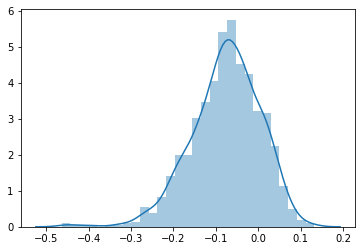

In [87]:
print('mean modularity:', np.mean(mod_values))
sns.distplot(mod_values)

In [81]:
# compare to karate club mean degree:

print('Karate club mean degree:', np.mean(list(dict(nx.degree(G)).values())))
print('Simulation mean degree:', np.mean(degree_values))


Karate club mean degree: 4.588235294117647
Simulation mean degree: 4.434117647058823


In [91]:
# now let's see what happens to the modularity of the random graph if we underestimate the degree in the null model:

Simulation mean degree: 4.450117647058823
mean modularity: 0.25672539122259935


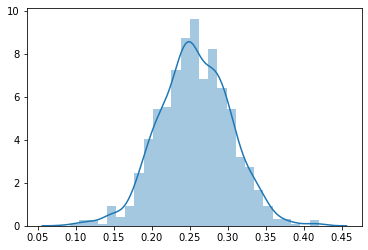

In [92]:
mod_values, degree_values = random_graph_modularity(n, p, Pmult=0.01)
print('mean modularity:', np.mean(mod_values))
sns.distplot(mod_values)